In [1]:
import pandas as pd

pairs1_path = '../../pairs.csv'
pairs1 = pd.read_csv(pairs1_path)
pairs2_path = '../../pairs2.csv'
pairs2 = pd.read_csv(pairs2_path)

print(len(pairs1))
print(len(pairs2))
# concat
pairs = pd.concat([pairs1, pairs2], ignore_index=True)
#drop duplicates
pairs = pairs.drop_duplicates()
print(len(pairs))

500
1000
1500


In [2]:
first_col = pairs["first"]
second_col = pairs["second"]
# get unique ids
unique_ids = set(first_col + second_col)
print(len(unique_ids))

1478


In [3]:
import re

def process_single_generation_result(gen_result):
    cleaned_generated_text = ""
    full_original_text = gen_result['original_text']
    prompt = gen_result['prompt']
    entities = gen_result['entities']
    
    # Remove the prompt from generated text
    generate_text = gen_result['generated_text'].replace(prompt, '')
    gen_lines = generate_text.split('\n')

    all_str_list = []
    # Extract strings in between '|'
    for line in gen_lines:
        text = line.split('|')
        if len(text) == 1:
            continue
        else:
            text = text[-2]

        if text == '' or text == ' ':
            pass
        elif re.match(r'^-?\d+(?:\.\d+)?$', text):  # Check if the text is a number
            pass
        else:
            all_str_list.append(text)
    
    cleaned_generated_text = '\n'.join(all_str_list)
    
    ent_list = []
    for line in entities.split('\n'):
        ent_list.extend([e for e in line.split(',') if e != ''])
    
    return {
        'cleaned_generated_text': cleaned_generated_text,
        'full_original_text': full_original_text,
        'prompt': prompt,
        'entities': ent_list
    }

def clean_entity(ent_key):
    ent_key = ent_key.replace('[pos]', '')            
    ent_key = ent_key.replace('[neg]', '')
    ent_key = ent_key.strip()
    return ent_key
    

import pickle

dict_path = '../Anonymization/negated_test_final_normalized_dict.pkl'
with open(dict_path, 'rb') as f:
    normalized_dict = pickle.load(f)

def map_entities(entity_pair):
    entity_map = {}
    
    # Get difference between the first and second entity lists
    diff = set(entity_pair[0]) - set(entity_pair[1])
    
    # Clean the entities
    cleaned_entities = [clean_entity(e) for e in diff]
    cleaned_anon_entities = [clean_entity(e) for e in entity_pair[1]]
    
    # Map entities to their normalized counterparts
    for ent in cleaned_entities:
        if ent == '':
                continue
        if ent in normalized_dict:
            normalized_ent = normalized_dict[ent]
            if normalized_ent in cleaned_anon_entities:
                entity_map[ent] = normalized_ent
            else:
                entity_map[ent] = "[DELETED]"
        else:
            entity_map[ent] = "[DELETED]"
    
    return entity_map

In [4]:
import random
# set seed
random.seed(42)

def jaccard_similarity(bow1, bow2):
    # Convert BoW to sets of word IDs (ignoring word counts)
    set1 = set([word_id for word_id, _ in bow1])
    set2 = set([word_id for word_id, _ in bow2])
    
    # Calculate the Jaccard similarity
    intersection = set1.intersection(set2)
    union = set1.union(set2)
    
    if not union:  # Avoid division by zero
        return 0.0
    
    return len(intersection) / len(union)

def find_most_similar_bow(bow, bow_list):
    max_similarity = -1
    most_similar_bow = None
    suffled_ids = list(range(len(bow_list)))
    random.shuffle(suffled_ids)
    
    #for i, candidate_bow in enumerate(bow_list):
    for i in suffled_ids:
        candidate_bow = bow_list[i]
        similarity = jaccard_similarity(bow, candidate_bow)
        if similarity > max_similarity:
            max_similarity = similarity
            most_similar_bow = candidate_bow
            most_similar_id = i

    
    return most_similar_bow, max_similarity, most_similar_id

import tqdm

def get_prediction(bow_list, org_bow_list):
    predictions = []
    similarities = []
    for i, bow in tqdm.tqdm(enumerate(org_bow_list), total=len(org_bow_list)):
        most_similar_bow, similarity, most_similar_id = find_most_similar_bow(bow, bow_list)
        predictions.append(most_similar_id)
        similarities.append(similarity)
    return predictions, similarities

In [5]:
import os

"""
generated_dir1 = '../_data/generation_results_ablation/'
generated_dir2 = '../_data/generation_results_ablation2/'

generated_dir = '../_data/generation_results_ablation_all/'

# copy all files from generated_dir2 and generated_dir1 to generated_dir
# if exists in generated_dir, delete it and create new one

os.makedirs(generated_dir, exist_ok=True)
generated_files1 = os.listdir(generated_dir1)
generated_files2 = os.listdir(generated_dir2)

for f in generated_files1:
    if os.path.exists(os.path.join(generated_dir, f)):
        os.remove(os.path.join(generated_dir, f))
    os.system('cp {} {}'.format(os.path.join(generated_dir1, f), os.path.join(generated_dir, f)))

for f in generated_files2:
    if os.path.exists(os.path.join(generated_dir, f)):
        os.remove(os.path.join(generated_dir, f))
    os.system('cp {} {}'.format(os.path.join(generated_dir2, f), os.path.join(generated_dir, f)))
"""
anonymized_dir = '../../generation_results_all/'
generated_dir = '../../generation_results_ablation_all/'
memorization_dir = '../../generation_results_ablation_memorization_all/'

anonymized_files = os.listdir(anonymized_dir)
anonymized_row_ids = [int(f.split('.')[0]) for f in anonymized_files]
generated_files = os.listdir(generated_dir)
generated_row_ids = [int(f.split('.')[0]) for f in generated_files]
memorization_files = os.listdir(memorization_dir)
memorization_row_ids = [int(f.split('.')[0]) for f in memorization_files]

In [6]:
# intersection of all three
common_row_ids = list(set(anonymized_row_ids) & set(generated_row_ids) & set(memorization_row_ids))
# open files of three directories and save as dict
# file is in the json format
anonymized_dict = {}
generated_dict = {}
memorization_dict = {}

import json

for row_id in common_row_ids:
    with open(os.path.join(anonymized_dir, str(row_id) + '.json')) as f:
        anonymized_dict[row_id] = json.load(f)
    with open(os.path.join(generated_dir, str(row_id) + '.json')) as f:
        generated_dict[row_id] = json.load(f)
    with open(os.path.join(memorization_dir, str(row_id) + '.json')) as f:
        memorization_dict[row_id] = json.load(f)

In [7]:
len(anonymized_dict), len(generated_dict), len(memorization_dict)

(1796, 1796, 1796)

In [8]:
anonymized_dict[8195].keys()

dict_keys(['generated_text', 'original_text', 'prompt', 'entities'])

In [9]:
print(len(generated_files))
print(len(memorization_files))
#print(len(generated_files1))
#print(len(generated_files2))

1796
1796


In [10]:
import json

results_dict = {}
entity_pairs_list_dict = {}

# iter rows in pairs
for i, row in pairs.iterrows():
    first_id = row['first']
    second_id = row['second']
    try:
        # import as json
        with open(generated_dir+str(first_id)+'.json') as f:
            first_generated = json.load(f)
        with open(generated_dir+str(second_id)+'.json') as f:
            second_generated = json.load(f)
        with open(anonymized_dir+str(first_id)+'.json') as f:
            first_anonymized = json.load(f)
        with open(anonymized_dir+str(second_id)+'.json') as f:
            second_anonymized = json.load(f)
        
        with open(memorization_dir+str(first_id)+'.json') as f:
            first_memorization = json.load(f)
        with open(memorization_dir+str(second_id)+'.json') as f:
            second_memorization = json.load(f)
        
        first_gen_result = process_single_generation_result(first_generated)
        second_gen_result = process_single_generation_result(second_generated)
        first_anon_result = process_single_generation_result(first_anonymized)
        second_anon_result = process_single_generation_result(second_anonymized)
        first_memo_result = process_single_generation_result(first_memorization)
        second_memo_result = process_single_generation_result(second_memorization)

        #entity_pairs_list.append((first_gen_result['entities'], first_anon_result['entities']))
        #entity_pairs_list.append((second_gen_result['entities'], second_anon_result['entities']))
        entity_pairs_list_dict[first_id] = {'first': (first_gen_result['entities'], first_anon_result['entities'], first_memo_result['entities']),
                                            'second': (second_gen_result['entities'], second_anon_result['entities'], second_memo_result['entities'])}
        
        results_dict[first_id] = {
            'gen_first': first_gen_result['cleaned_generated_text'],
            'gen_second': second_gen_result['cleaned_generated_text'],
            'anon_first': first_anon_result['cleaned_generated_text'],
            'anon_second': second_anon_result['cleaned_generated_text'],
            'memo_first': first_memo_result['cleaned_generated_text'],
            'memo_second': second_memo_result['cleaned_generated_text'],
            'org_first': first_gen_result['full_original_text'],
            'org_second': second_gen_result['full_original_text'],
            'second_id': second_id
        }
    except FileNotFoundError:
        continue
    



In [11]:
for first_id in entity_pairs_list_dict.keys():
    first_entity_pair = entity_pairs_list_dict[first_id]['first']
    org_first = results_dict[first_id]['org_first']
    second_entity_pair = entity_pairs_list_dict[first_id]['second']
    org_second = results_dict[first_id]['org_second']

    first_entity_map = map_entities(first_entity_pair)
    second_entity_map = map_entities(second_entity_pair)

    for key, value in first_entity_map.items():
        org_first = org_first.replace(key, value)
    for key, value in second_entity_map.items():
        org_second = org_second.replace(key, value)
    
    results_dict[first_id]['rpl_first'] = org_first
    results_dict[first_id]['rpl_second'] = org_second


In [12]:
org_text_list = []
gen_text_list = []
anon_text_list = []
memo_text_list = []
rpl_text_list = []
id_list = []

for key, value in results_dict.items():
    org_text_list.append(value['org_first'])
    org_text_list.append(value['org_second'])
    gen_text_list.append(value['gen_first'])
    gen_text_list.append(value['gen_second'])
    anon_text_list.append(value['anon_first'])
    anon_text_list.append(value['anon_second'])
    memo_text_list.append(value['memo_first'])
    memo_text_list.append(value['memo_second'])
    rpl_text_list.append(value['rpl_first'])
    rpl_text_list.append(value['rpl_second'])
    id_list.append(key)
    id_list.append(value['second_id'])
    if len(id_list) == 1000:
        break

In [13]:
from rouge_score import rouge_scorer
import tqdm

def get_rouge_score(org_text_list, target_text_list):
    score_list = []
    #for target_text in target_text_list:
    for i in tqdm.tqdm(range(len(target_text_list)), total=len(target_text_list)):
        target_text = target_text_list[i]
        org_text = org_text_list[i]
        
        scorer = rouge_scorer.RougeScorer(['rougeL'], use_stemmer=True)
        scores = scorer.score(org_text, target_text)
        score_list.append(scores['rougeL'].fmeasure)
    return score_list

gen_rouge_scores = get_rouge_score(org_text_list, gen_text_list)
anon_rouge_scores = get_rouge_score(org_text_list, anon_text_list)
memo_rouge_scores = get_rouge_score(org_text_list, memo_text_list)
rpl_rouge_scores = get_rouge_score(org_text_list, rpl_text_list)

100%|██████████| 1000/1000 [01:33<00:00, 10.75it/s]


In [18]:
# get basic statistics of rouge scores
import numpy as np

gen_rouge_scores = np.array(gen_rouge_scores)
anon_rouge_scores = np.array(anon_rouge_scores)
memo_rouge_scores = np.array(memo_rouge_scores)
rpl_rouge_scores = np.array(rpl_rouge_scores)

print(gen_rouge_scores.mean().round(3), gen_rouge_scores.std().round(3), gen_rouge_scores.max().round(3), gen_rouge_scores.min().round(3))
print(anon_rouge_scores.mean().round(3), anon_rouge_scores.std().round(3), anon_rouge_scores.max().round(3), anon_rouge_scores.min().round(3))
print(memo_rouge_scores.mean().round(3), memo_rouge_scores.std().round(3), memo_rouge_scores.max().round(3), memo_rouge_scores.min().round(3))
print(rpl_rouge_scores.mean().round(3), rpl_rouge_scores.std(.round(3)), rpl_rouge_scores.max().round(3), rpl_rouge_scores.min().round(3))


0.393 0.08084018930119556 0.7001194743130227 0.0
0.33299905636815197 0.08224302125420152 0.5751824817518247 0.0243531202435312
0.5278859807943904 0.20516980341623706 1.0 0.0
0.8097219892914657 0.2354860302018417 0.9980430528375733 0.08098891730605286


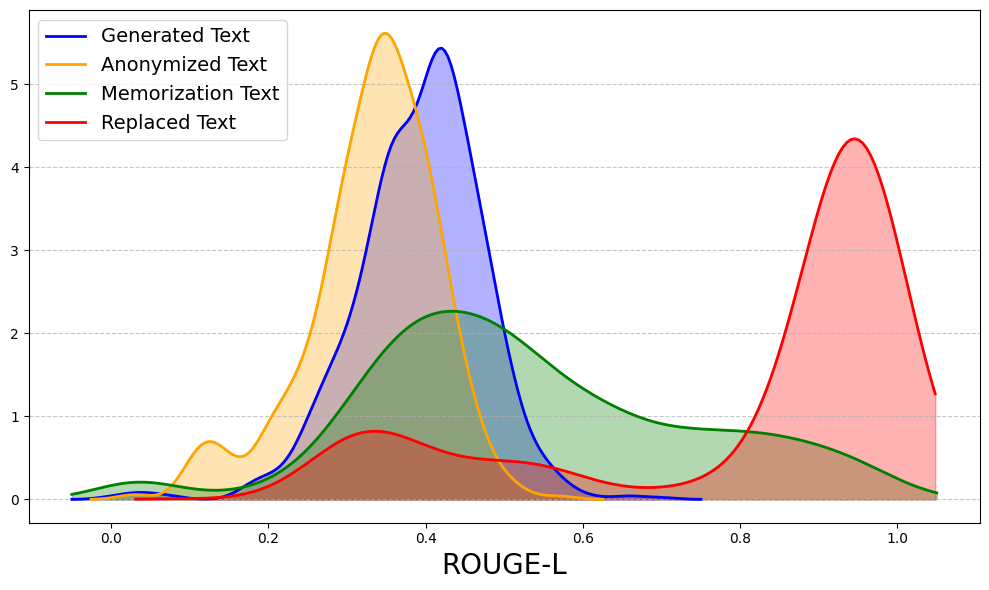

In [15]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import gaussian_kde

# Function to plot a density curve with filled area
def plot_density_curve(ax, scores, label, color):
    # Estimate the density using Gaussian KDE
    density = gaussian_kde(scores)
    xs = np.linspace(min(scores) - 0.05, max(scores) + 0.05, 200)
    ys = density(xs)
    ax.plot(xs, ys, label=label, color=color, linewidth=2)
    ax.fill_between(xs, ys, color=color, alpha=0.3)  # Fill area under the curve

# Create the plot
fig, ax = plt.subplots(figsize=(10, 6))

# Plot density curves for each set of scores
plot_density_curve(ax, gen_rouge_scores, "Generated Text", 'blue')
plot_density_curve(ax, anon_rouge_scores, "Anonymized Text", 'orange')
plot_density_curve(ax, memo_rouge_scores, "Memorization Text", 'green')
plot_density_curve(ax, rpl_rouge_scores, "Replaced Text", 'red')

# Customize the plot
#ax.set_title("ROUGE-L Distributions", fontsize=20)
ax.set_xlabel("ROUGE-L", fontsize=20)
#ax.set_ylabel("Density", fontsize=20)
ax.grid(axis='y', linestyle='--', alpha=0.7)
#ax.legend()
# set the font size of the legend
ax.legend(fontsize=14)

# Show the plot
plt.tight_layout()
#plt.show()
# save as high resolution image
#plt.savefig('rouge_score_distribution.png', dpi=300)

In [16]:
##scp seiji-sh@benihi.naist.jp:/home/is/seiji-sh/TwinRecord/TwinRecord_scripts/Analysis/rouge_score_distribution.png /Users/seiji-sh/Downloads/
#TwinRecord_scripts/Analysis/rouge_score_distribution.png